# Look at LDA of Beaded Helix

## Import Libraries

In [96]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
from shapeGMMTorch import torch_sgmm, torch_align
import torch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read trajectory

In [97]:
prmtopFileName = "../helix_template.pdb"
trajFileNamev03 = "../run_v03/helix_folding_eps6.0.dcd"
trajFileNamev04 = "../run_v04/helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileNamev03,trajFileNamev04)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 2000002
Number of atoms in selection: 12


## Load weights

In [98]:
eps_range = np.array([4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7])
eps_str = np.array(['4.5', '4.6', '4.7', '4.8','4.9','5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4', '6.5', '6.6', '6.7','6.8', '6.9','7.0']).astype(str)
weights = []
for i, eps in enumerate(eps_str):
    label = "$\epsilon=$" + eps
    file_name_1 = "../run_v03/eps" + eps + "_frame_weights.dat"
    file_name_2 = "../run_v04/eps" + eps + "_frame_weights.dat"
    weights.append(np.concatenate((np.loadtxt(file_name_1),np.loadtxt(file_name_2))))
weights = np.array(weights)
n_frames = weights.shape[1]
print(n_frames)

2000002


In [89]:
# make sure they are the same length
traj_data = traj_data[:n_frames]

## Perform LDA of $\epsilon=6$

In [99]:
# load object
# eps=6 three clusters
import pickle
fileObj = open('../sgmm3.obj', 'rb')
sgmm3_eps6 = pickle.load(fileObj)
fileObj.close()
cluster_ids = sgmm3_eps6.predict(traj_data)[0]

In [100]:
indeces = np.concatenate((np.argwhere(cluster_ids==0).flatten(),np.argwhere(cluster_ids==1).flatten()))

In [101]:
dtype = torch.float64
device = torch.device("cpu")
traj_tensor = torch.tensor(traj_data[indeces], dtype=dtype, device=device)
torch_align.torch_remove_center_of_geometry(traj_tensor,dtype=dtype,device=device)
aligned_traj_tensor, aligned_avg_tensor, aligned_precision_tensor = torch_align.torch_iterative_align_kronecker(traj_tensor, dtype=dtype,device=device,max_iter=400)[:3]
aligned_traj = aligned_traj_tensor.cpu().numpy()

In [102]:
# align entire trajectory given this mean and precision
traj_tensor = torch.tensor(traj_data, dtype=dtype, device=device)
torch_align.torch_remove_center_of_geometry(traj_tensor,dtype=dtype,device=device)
aligned_traj_tensor = torch_align.torch_align_kronecker(traj_tensor,aligned_avg_tensor,aligned_precision_tensor,dtype=dtype,device=device)
aligned_traj = aligned_traj_tensor.cpu().numpy()

In [103]:
eps6_lda = lda()
eps6_lda.fit(aligned_traj.reshape(-1,aligned_traj.shape[1]*aligned_traj.shape[2])[indeces],cluster_ids[indeces])
eps6_lda_projection = eps6_lda.transform(aligned_traj.reshape(-1,aligned_traj.shape[1]*aligned_traj.shape[2]))

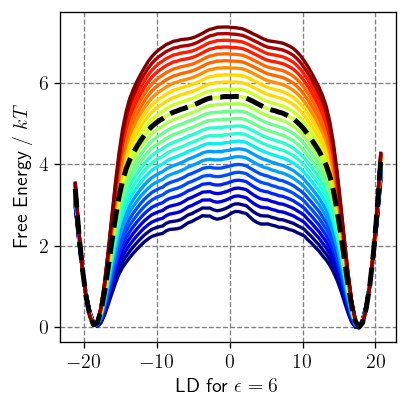

In [108]:
from scipy.signal import savgol_filter
import matplotlib as mpl
plt.rc('text', usetex=True)
eps6_lda_prob, edges = np.histogram(eps6_lda_projection,bins=np.arange(-21.5,21.5,0.5),density=True)
fe = -np.log(eps6_lda_prob)
fe = savgol_filter(fe, 5, 2)
fe -= np.amin(fe)
centers = 0.5*(edges[:-1]+edges[1:])
# plot
colors = ["black", "blue", "red", "orange"]
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5), dpi= 120, facecolor='w', edgecolor='k')
fontsize=12
eps_range = np.array([4.5, 4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7])
eps_str = np.array(['4.5', '4.6', '4.7', '4.8','4.9','5.0', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6.0', '6.1', '6.2', '6.3', '6.4', '6.5', '6.6', '6.7','6.8', '6.9','7.0']).astype(str)
c = np.arange(np.amin(eps_range),np.amax(eps_range)+0.1,0.1)
cmap = mpl.cm.get_cmap('jet', c.size)
# Make dummie mappable
dummie_cax = ax.scatter(c, c, c=c, cmap=cmap)
ax.cla()
for i, eps in enumerate(eps_str):
    label = "$\epsilon=$" + eps
    c_bin = int((eps_range[i]-np.amin(eps_range))/0.1)
    lda_prob, edges = np.histogram(eps6_lda_projection[:,0],bins=np.arange(-21.5,21.5,0.5),density=True,weights=weights[i])
    fe = -np.log(lda_prob)
    fe = savgol_filter(fe, 11, 2)
    fe -= np.amin(fe)
    ax.plot(centers,fe,lw=2,label=label, c=cmap(c_bin))
fe = -np.log(eps6_lda_prob)
fe = savgol_filter(fe, 11, 2)
fe -= np.amin(fe)
ax.plot(centers,fe,'--',lw=3,label=label, c='k')
ax.grid(which='major', axis='both', color='#808080', linestyle='--')
ax.set_xlabel("LD for $\epsilon=6$",fontsize=fontsize)
ax.set_ylabel("Free Energy / $kT$",fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)
#cbar = fig.colorbar(dummie_cax, ticks=np.round(np.linspace(np.amin(eps_range),np.amax(eps_range),7),1))
#cbar.set_label("Reweighted $\epsilon$",fontsize=fontsize)
plt.tight_layout()
plt.savefig("beaded_helix_reweighted_lda_fe.pdf",dpi=300)

## write cluster trajectories

In [4]:
from shapeGMMTorch import scripts
scripts.write_cluster_trajectories(sgmm3_eps6)

In [53]:
# write cluster trajectories
def write_cluster_trajectories(traj_data, cluster_ids):
    """
    Write trajectories for each cluster from trajectory data and cluster ids
    """
    # get meta data from inputs
    n_frames = traj_data.shape[0]
    n_atoms = traj_data.shape[1]
    n_cluster_frames = np.unique(cluster_ids,return_counts=True)[1]
    n_clusters = n_cluster_frames.size
    # loop through clusters
    for cluster_id in range(n_clusters):
        # create MDAnalysis universe
        u = md.Universe.empty(n_atoms, 1, atom_resindex=np.zeros(n_atoms), trajectory=True)
        u.trajectory.n_frames = n_cluster_frames[cluster_id]
        sel_all = u.select_atoms("all")
        trj = traj_data[cluster_ids==cluster_id]
        pdb_file_name = "cluster" + str(cluster_id+1) + "_frame1.pdb"
        dcd_file_name = "cluster" + str(cluster_id+1) + "_" + str(n_cluster_frames[cluster_id]) + "frames.dcd"
        # write pdb of mean structure
        sel_all.positions = trj[0]
        sel_all.write(pdb_file_name)
        # write dcd of generated trajectory
        with md.Writer(dcd_file_name, sel_all.n_atoms) as W:
            for ts in range(n_cluster_frames[cluster_id]):
                sel_all.positions = trj[ts]
                W.write(sel_all)
        W.close()

In [49]:
np.unique(cluster_ids,return_counts=True)[1]

array([405757, 417045, 113642])

In [47]:
trj = traj_data[cluster_ids==0]

In [48]:
print(trj.shape)

(405757, 12, 3)


In [54]:
write_cluster_trajectories(traj_data,cluster_ids)

In [57]:
np.argmax(sgmm3_eps6.predict_frame_log_likelihood[cluster_ids==2])

12995

In [65]:
sgmm3_eps6.predict_frame_log_likelihood[cluster_ids==2][12995]

32.82335469226186

In [83]:
# write representative frames
def write_representative_frames(sgmm, traj_data, cluster_ids):
    """
    Write representative frames for each cluster
    This is defined as the frame with the largest LL to each cluster
    """
    # get meta data from inputs
    n_frames = traj_data.shape[0]
    n_atoms = sgmm.n_atoms
    n_clusters = sgmm.n_clusters
    # loop through clusters
    for cluster_id in range(n_clusters):
        # create a shapeGMM object with just this cluster
        sgmmM = torch_sgmm.ShapeGMMTorch(1,covar_type=sgmm.covar_type,device=torch.device("cpu"),dtype=sgmm.dtype)
        sgmmM.weights = np.array([1.0])
        sgmmM.centers = sgmm.centers[cluster_id].reshape(1,n_atoms,3)
        sgmmM.precisions = sgmm.precisions[cluster_id].reshape(1,n_atoms,n_atoms)
        sgmmM.lpdets = np.array([sgmm.lpdets[cluster_id]])
        sgmmM.n_atoms = sgmm.n_atoms
        sgmmM._gmm_fit_flag = True
        # compute LL using the predict function
        indeces = np.argwhere(cluster_ids==cluster_id).flatten()
        sgmmM.predict(traj_data[indeces])
        representive_frame_id = indeces[np.argmax(sgmmM.predict_frame_log_likelihood)]
        # create MDAnalysis universe to print frame
        u = md.Universe.empty(n_atoms, 1, atom_resindex=np.zeros(n_atoms), trajectory=True)
        sel_all = u.select_atoms("all")
        # print pdb
        pdb_file_name = "cluster" + str(cluster_id+1) + "_reperesentative_frame_" + str(representive_frame_id+1) + ".pdb"
        sel_all.positions = traj_data[representive_frame_id]
        sel_all.write(pdb_file_name)

In [84]:
write_representative_frames(sgmm3_eps6,traj_data,cluster_ids)

In [86]:
cluster_ids[105457]

2